# Multi-ConvNet Architectures

In this notebook, we concatenate *multiple parallel convolutional nets together* to classify IMDB movie reviews by their sentiment.

#### Load dependencies

In [1]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model # new!
from keras.layers import Input, concatenate # new! 
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, Conv1D, GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
%matplotlib inline

Using TensorFlow backend.


#### Set hyperparameters

In [2]:
# output directory name:
output_dir = 'model_output/multiconv'

# training:
epochs = 4
batch_size = 128

# vector-space embedding: 
n_dim = 64
n_unique_words = 5000 
max_review_length = 400
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# convolutional layer architecture:
n_conv_1 = n_conv_2 = n_conv_3 = 256 
k_conv_1 = 3
k_conv_2 = 2
k_conv_3 = 4

# dense layer architecture: 
n_dense = 256
dropout = 0.2

#### Load data

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) 

#### Preprocess data

In [4]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### Design neural network architecture

In [5]:
# start with conv_1 only and no concat
# add conv_2
# add conv_3
# add dense_2

input_layer = Input(shape=(max_review_length,), dtype='int16', name='input') # supports integers +/- 32.7k 
embedding_layer = Embedding(n_unique_words, n_dim, input_length=max_review_length, name='embedding')(input_layer)
drop_embed_layer = SpatialDropout1D(drop_embed, name='drop_embed')(embedding_layer)

conv_1 = Conv1D(n_conv_1, k_conv_1, activation='relu', name='conv_1')(drop_embed_layer)
maxp_1 = GlobalMaxPooling1D(name='maxp_1')(conv_1)

conv_2 = Conv1D(n_conv_1, k_conv_1, activation='relu', name='conv_2')(drop_embed_layer)
maxp_2 = GlobalMaxPooling1D(name='maxp_2')(conv_2)

conv_3 = Conv1D(n_conv_1, k_conv_1, activation='relu', name='conv_3')(drop_embed_layer)
maxp_3 = GlobalMaxPooling1D(name='maxp_3')(conv_3)

concat = concatenate([maxp_1, maxp_2, maxp_3])

dense_layer = Dense(n_dense, activation='relu', name='dense')(concat)
drop_dense_layer = Dropout(dropout, name='drop_dense')(dense_layer)
dense_2 = Dense(64, activation='relu', name='dense_2')(drop_dense_layer)
dropout_2 = Dropout(dropout, name='drop_dense_2')(dense_2)

predictions = Dense(1, activation='sigmoid', name='output')(dropout_2)

model = Model(input_layer, predictions)

In [6]:
model.summary() 

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, 400)           0                                            
____________________________________________________________________________________________________
embedding (Embedding)            (None, 400, 64)       320000      input[0][0]                      
____________________________________________________________________________________________________
drop_embed (SpatialDropout1D)    (None, 400, 64)       0           embedding[0][0]                  
____________________________________________________________________________________________________
conv_1 (Conv1D)                  (None, 398, 256)      49408       drop_embed[0][0]                 
___________________________________________________________________________________________

#### Configure model

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [9]:
# start with conv_1 only and no concat: 89.1% validation accuracy in epoch 2, as earlier notebook
# add conv_2: 89.5% in epoch 3
# add conv_3: ditto
# add dense_2: ditto in epoch 2
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 36s - loss: 0.5104 - acc: 0.7124 - val_loss: 0.2899 - val_acc: 0.8800
Epoch 2/4
25000/25000 [==============================] - 6s - loss: 0.2538 - acc: 0.9010 - val_loss: 0.2591 - val_acc: 0.8940
Epoch 3/4
25000/25000 [==============================] - 7s - loss: 0.1742 - acc: 0.9356 - val_loss: 0.2787 - val_acc: 0.8875
Epoch 4/4
25000/25000 [==============================] - 7s - loss: 0.1222 - acc: 0.9573 - val_loss: 0.2903 - val_acc: 0.8912


#### Evaluate

In [10]:
model.load_weights(output_dir+"/weights.01.hdf5") # zero-indexed

In [11]:
y_hat = model.predict(x_valid)

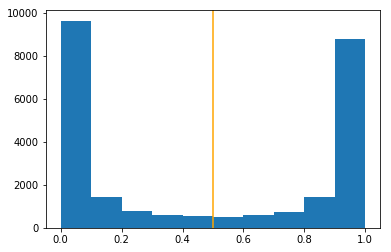

In [12]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [13]:
round(roc_auc_score(y_valid, y_hat)*100.0)

96.0